As of Feb 2025, Python 3.13 (default in BAS since this month) is not supported by `tensorflow` package, so conda to be used.

## Preview the machine-generated images of pets

You will be working on a set of machine-generated images of the most popular (again, accordingly to the GenAI) breeds of cats and dogs. Images are stored in the folder [./pets/](./pets/) 

In [1]:
from PIL import Image as PILImage
from IPython.display import display

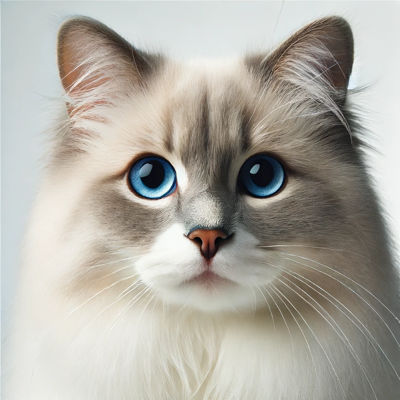

In [2]:
dir_images='./pets/'

img = PILImage.open(dir_images+'21_Ragdoll.webp')
display(img.resize((400, 400)))

## Get image [embeddings](https://help.sap.com/docs/hana-cloud-database/sap-hana-cloud-sap-hana-database-vector-engine-guide/vectors-vector-embeddings-and-metrics)

You will use `ResNet50V2` model from https://keras.io/api/applications/#available-models to get embeddings of the images.

Ignore possible information `I` and warning `W` messages from the first `tensorflow` import below.

In [3]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing import image as tf_image

import pandas as pd
import numpy as np
# from tqdm.auto import tqdm

2025-03-25 21:07:30.217621: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 21:07:30.967164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
mymodel = ResNet50V2(include_top=False, weights='imagenet', pooling='avg')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


The model ResNet50V2 will be downloaded during the first instantiation to the folder `~/.keras/models/`.

In [5]:
!ls -lh ~/.keras/models/

total 91M
-rw-r--r-- 1 user group 91M Mar 25 21:07 resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5


To speed up processing a bit you will reduce the size of the images by half `1024//2`. Please note the use of `//` to have integer number as a result.

In [6]:
#Function to get embeddings

def get_image_embedding(model, img_path):
    img = tf_image.load_img(img_path, target_size=(1024//2, 1024//2))
    x = tf_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embeddings = model.predict(x)  
    result = pd.DataFrame(embeddings[0]).T
    return result

Get embeddings for all images in the source directory and store them in the `embedding_df` Pandas DataFrame for now.

In [7]:
import os
import pandas as pd

dir_images = './pets/'

path_images = os.listdir(dir_images)
embedding_df = pd.DataFrame()
for current_img in path_images:
    curr_df = get_image_embedding(model=mymodel, img_path=dir_images + current_img)
    curr_df['image'] = current_img
    embedding_df = pd.concat([embedding_df, curr_df], ignore_index=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


In [8]:
# Check one of the generated embeddings
display(embedding_df.iloc[0])

# Note 2048 fileds with real numbers for dimensions from 0 to 2047, plus the file name in the last field.

0                      0.047023
1                           0.0
2                      1.245705
3                      6.184107
4                           0.0
                  ...          
2044                   0.023627
2045                   0.005333
2046                    0.30996
2047                   0.032885
image    13_GermanShepherd.webp
Name: 0, Length: 2049, dtype: object

In [10]:
import pickle

# # Open a file in binary write mode
with open('/tmp/image_embeddings.pkl', 'wb') as file:
    # Serialize the list and write it to the file
    pickle.dump(embedding_df, file)

> Switch to virtual env now to load to HANA db.

In [1]:
import pickle

# Open the file in binary read mode
with open('/tmp/image_embeddings.pkl', 'rb') as file:
    # Deserialize the list from the file
    embedding_df = pickle.load(file)

print(len(embedding_df))

19


## Load the model into SAP HANA's Vector Engine

In [2]:
%run "../01-check_setup.ipynb"

SAP HANA Client for Python: 2.23.25031700
Connected to SAP HANA db version 4.00.000.00.1741685756 (fa/CE2024.40) 
at f312cb5c-25c5-46d5-a939-e9b97abc39ea.hna2.prod-eu10.hanacloud.ondemand.com:443 as SURGE01
Current time on the SAP HANA server: 2025-03-25 21:09:28.388000


## Upload into your SAP HANA database

...similarly to how you uploaded word vectors during the Week 2 exercise.

In [3]:
source_table="IMAGES"
source_schema="VECTORS"

In [4]:
myconn.connection.setautocommit(True)
mycursor = myconn.connection.cursor()

try:
    mycursor.execute(f'DROP TABLE "{source_schema}"."{source_table}"')
    myconn.connection.commit()

except Exception as e:
    # Handle any exceptions and possibly rollback the transaction
    myconn.connection.rollback()
    print("An error occurred:", e)

An error occurred: (259, 'invalid table name: IMAGES: line 1 col 22 (at pos 21)')


The table `IMAGES` will store:
- a file name in `"IMAGE_NAME"`
- a breed name in `"NAME"`
- an **i**mage embedding (or **v**ector) in `"IV"`
- a Base64-encoded image of a pet in `"IMAGE"`

In [5]:
myconn.create_table(
    source_table, schema=source_schema,
    table_structure={
        "IMAGE_NAME": "NVARCHAR(50)", 
        "NAME": "NVARCHAR(50)", 
        "IV": "REAL_VECTOR(2048)",
        "IMAGE": "NCLOB"
        }
    )

## Get image Base64 encodings to be stored in the database table 

In [6]:
from io import BytesIO
import base64

In [7]:
# Function to open and encode an image to Base64
def get_image_encoding(image_path, size=(400, 400)):
    img_resized = PILImage.open(image_path).resize(size)
    buffer = BytesIO()
    img_resized.save(buffer, format="WEBP")
    encoded_img = base64.b64encode(buffer.getvalue()).decode('utf-8')
    return encoded_img


In the next cell, prepare the list of records `myrecords_to_insert` to be inserted into the database.

Each record has 4 fields with:
- a file name: `[myrow[-1:][0]`
- a breed name derived from a file name: `myrow[-1:][0].split('.')[0].split('_')[1]`
- image encoding: `get_image_encoding(dir_images+myrow[-1:][0])` for an image read from the file name
- a string representation of a vector embedding `str(myrow[:-1])`

In [9]:
from PIL import Image as PILImage
from IPython.display import display

In [10]:
%%time
dir_images = './pets/'
my_embeddings=embedding_df.values.tolist()

myrecords_to_insert=[
    [myrow[-1:][0], 
    myrow[-1:][0].split('.')[0].split('_')[1], 
    get_image_encoding(dir_images+myrow[-1:][0]), 
    str(myrow[:-1])] 
    for myrow in my_embeddings]

CPU times: user 694 ms, sys: 119 ms, total: 813 ms
Wall time: 822 ms


In [11]:
#Display one of the records to see its all 4 fields
display(myrecords_to_insert[0])

['13_GermanShepherd.webp',
 'GermanShepherd',
 'UklGRoJIAABXRUJQVlA4IHZIAACwJAGdASqQAZABPm0wlEckIyIhKLV7OIANiWVu4O5jx8aKumoyDiaV/yypPeRfI0IfeHz0Hx/Uxz8/V//2+g49RXngdW9vUuQBy1WoGun9L/Ef6HjOdreZH3xz4dpf6/4hzzP4HmO/S+bvhB/C+oF5jf+vxOqBflM99H97/8HsG9MD0eP3OOY8AqCabs2ETx5cUHf3Le+UFzBynZ+cGKcjUdUOThlmCpeIhr1aHKQfOQOGHyo0/2LugD9DcFuYWeYlVub5niqWGYJcw+ILXX7E7keqckMFeMzS8bJtGAPItK1p1qbfBfx480c+iuk+HKSxzzunvKm+RAwOJw0nj9Z5IbN/Y/gVx9n0s57kQmi1ErNXFtamhvyk1XIotzp1gIUbj7gXpqQ6qsLUB2N9vYtAZ6a89rpfhMy+i5HI/xsns5a5tK9Y972zdrcnliXGF6JLN4a/nkBmPDbprrBaZr1+EIatJpSTB7Y4oorkPQh/a53cRnAVvdVg9B74LeHIvJVvc42qQT9Cxr0sywKINWZ5ioJVOcue5IZH0yFGkhHV8B13LKQakGZCyYnTZutGkpUFls618GIH2KaM6XFwz/IdEzU9QISoq/CVrFODCg6wbA+G6FILk9XwJ1QcGcvGgPLEZxrdKFm0qgj2GEKGJv5uFVOQOEJR2JhOMhYsg5xAM039OCiQckjRvA8OGjc/mjCtE34Eei5rd6k5/xKbAOKlDwbDa/no9wBIg84IOVxoKmM2RzecSkT4cGtXw9dmUYn9PAOVqe77YbbfSbl1gy6Xs1M/4u7qL9co1W5xzYbuc5ibGg2APRhF7aGo9Lk2NBG/PQ2juFKX3rZcttUxmsO35N1WKY1kd1rkBCHkNFNoXaNrlL2aiLkKKd+XZ2oVIuCpu7Yc07T0W09WdYdhBpN1h4IbeYdZ

In [12]:
%%time
myconn.connection.setautocommit(False)
cursor = myconn.connection.cursor()

try:
    mycursor.execute(f'TRUNCATE TABLE "{source_schema}"."{source_table}"')
    # Use the executemany method to insert the data
    cursor.executemany(
        f'''INSERT INTO "{source_schema}"."{source_table}" ("IMAGE_NAME", "NAME", "IMAGE", "IV") VALUES (?, ?, ?, TO_REAL_VECTOR(?))''', 
        myrecords_to_insert
    )

except Exception as e:
    # Handle any exceptions and possibly rollback the transaction
    myconn.connection.rollback()
    print("An error occurred:", e)

CPU times: user 7.06 ms, sys: 299 μs, total: 7.36 ms
Wall time: 74.4 ms


In [13]:
%%time
try:
    # Commit the transaction to save the changes
    myconn.connection.commit()

finally:
    # Close the cursor and the connection when done
    cursor.close()

CPU times: user 735 μs, sys: 159 μs, total: 894 μs
Wall time: 3.87 ms


## Check data in the database table

In [14]:
## Check the size of the table in the database
print(f"Number of records in the table {source_table}: {myconn.table(table=source_table, schema=source_schema).count()}")

Number of records in the table IMAGES: 19


In [15]:
## Display a record for one of the entries
word='MaineCoon'

sql = f'''
SELECT "A".* FROM "{source_schema}"."{source_table}" AS "A"
WHERE "A"."NAME"='{word}'
'''

hdf = myconn.sql(sql)
print(hdf.select_statement)
hdf.head(3).collect()


SELECT "A".* FROM "VECTORS"."IMAGES" AS "A"
WHERE "A"."NAME"='MaineCoon'


,IMAGE_NAME,NAME,IV,IMAGE
0,22_MaineCoon.webp,MaineCoon,"[0.009091056883335114, 0.07366035133600235, 1....",UklGRlCGAABXRUJQVlA4IESGAACwlQGdASqQAZABPmkqkE...


Note that the `"IV"` column is binary and can be represented in different formats in different database client tools, as mentioned by Dirk O. in his comment: https://community.sap.com/t5/application-development-discussions/questions-re-quot-multi-model-with-sap-hana-cloud-quot-developer-challenge/m-p/13732043/highlight/true#M2028526

It is only when transofrmed to the string with [`TO_NVARCHAR()`](https://help.sap.com/docs/hana-cloud-database/sap-hana-cloud-sap-hana-database-vector-engine-guide/to-nvarchar-function-data-type-conversion?version=2024_1_QRC&locale=en-US) then you can see its vector representation.

In [16]:
## Display a record for one of the entries
word='MaineCoon'

sql = f'''
SELECT TO_NVARCHAR("IV") FROM "{source_schema}"."{source_table}" AS "A"
WHERE "A"."NAME"='{word}'
'''

hdf = myconn.sql(sql)
print(hdf.select_statement)

__import__("pandas").set_option('display.max_colwidth', 180)
display(hdf.head(3).collect())

__import__("pandas").reset_option('display.max_colwidth')


SELECT TO_NVARCHAR("IV") FROM "VECTORS"."IMAGES" AS "A"
WHERE "A"."NAME"='MaineCoon'


,TO_NVARCHAR(IV)
0,"[0.009091057,0.07366035,1.5812378,0.50655985,0.02220669,0.01369589,0.023843322,0.044057272,0.017793776,0.0018955916,0,0,0,0.14754005,0.0018018866,0.7582602,0.002096123,0.013185..."
